In [2]:
##import packages
library(ggplot2)
library(microbiome)
library(phyloseq)
library("tidyverse")
library("dplyr")
library(vegan)
library("lubridate")
library("DESeq2")
library("GGally")
library("ggpmisc")
library(patchwork)
library(lsmeans)
library('pbkrtest')
library("speedyseq")

In [3]:
library("lme4"); packageVersion("lme4")
packageVersion("microbiome")
packageVersion('Vegan')

[1] ‘1.1.35.3’

[1] ‘1.24.0’

[1] ‘2.6.4’

In [4]:
#import data from r data
load("/Users/stephanie.rosales/Documents/omics_projects/POR_16S/CoralPersistence/data/POR_counts_4_analysis.RData")
load("/Users/stephanie.rosales/Documents/omics_projects/POR_16S/CoralPersistence/data/POR_taxo_4_analysis.RData")
## import ASVs with euk similarities 
euk_ASVs <- read.table("/Users/stephanie.rosales/Documents/omics_projects/POR_16S/CoralPersistence/data/euk_asvs.txt",
                      stringsAsFactors = FALSE) %>% as.matrix() %>% as.list()
## Need taxonomy and counts as matrices
taxo_mat <- POR_taxo_4_analysis
count_mat <- as.matrix(POR_counts_4_analysis)
count_mat <- as.matrix(POR_counts_4_analysis)

In [5]:
#import metadata
meta = read.csv ("/Users/stephanie.rosales/Documents/omics_projects/POR_16S/CoralPersistence/metadata/POR_combo_meta.csv",
row.names=1, header = T)%>%
  mutate(
    Month = factor(Month, levels = month.name)
  ) %>%
  arrange(Month) %>% # change factor levels
arrange(collection_date)

In [6]:
# create phyloseq object
ASV <- otu_table(as.matrix(POR_counts_4_analysis), 
                 taxa_are_rows = T)
TAX <- tax_table(as.matrix(taxo_mat))
SAMP <- sample_data(meta)

ps <- phyloseq(ASV, TAX, SAMP)
ps

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 27534 taxa and 363 samples ]:
sample_data() Sample Data:        [ 363 samples by 58 sample variables ]:
tax_table()   Taxonomy Table:     [ 27534 taxa by 7 taxonomic ranks ]:
taxa are rows

In [7]:
#filter euks
euk_asvs <- c("ASV_10673","ASV_10883",	"ASV_11806","ASV_12333",	"ASV_12335",	"ASV_13587",	"ASV_14757",	"ASV_15238",	"ASV_15259",	"ASV_16364",	"ASV_16936",	"ASV_17406",	"ASV_18096",	"ASV_18375",	"ASV_18682",	"ASV_19529",	"ASV_19795",	"ASV_19953",	"ASV_2",	"ASV_20640",	"ASV_2100",	"ASV_22284",	"ASV_22692",	"ASV_23038",	"ASV_23144",	"ASV_24135",	"ASV_24243",	"ASV_27014",	"ASV_29665",	"ASV_30547",	"ASV_30626",	"ASV_30884",	"ASV_4161",	"ASV_4498",	"ASV_476",	"ASV_4797",	"ASV_4966",	"ASV_5018",	"ASV_5118",	"ASV_5154",	"ASV_6282",	"ASV_653",	"ASV_6843",	"ASV_7264",	"ASV_7427",	"ASV_8",	"ASV_9248",	"ASV_9692")
allTaxa = taxa_names(ps)
allTaxa <- allTaxa[!(allTaxa %in% euk_asvs)]
ps_fill_euk = prune_taxa(allTaxa, ps)
# new phyloseq object with just the taxa you kept.
ps_fill_euk

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 27486 taxa and 363 samples ]:
sample_data() Sample Data:        [ 363 samples by 58 sample variables ]:
tax_table()   Taxonomy Table:     [ 27486 taxa by 7 taxonomic ranks ]:
taxa are rows

In [8]:
#filter samples only sampled once

extras=c("apal_cf_gCN2_cl6_fr5_AH_2019-09-25",
  "apal_ndr_gCN2_cl15_fr4_AH_2019-11-19",
  "apal_pr_gCN2_cl75_fr6_AH_2019-11-18",
  "apal_ndr_gCN4_cl32_frB_AH_2019-11-19",
  "apal_pr_gCN4_cl98_fr4_AH_2019-09-26",
  "apal_cf_gHS1_cl15_frB_AH_2019-11-19",
  "apal_pr_gHS1_cl106_fr7_AH_2019-11-18",
  "apal_pr_gHS1_cl108_fr3_AH_2019-11-18",
  "apal_ndr_gML2_cl18_fr6_AH_2019-11-19",
  "apal_ndr_gCN1_cl17_fr4_AH_2019-09-25",
  "apal_pr_gCN4_cl98_fr4_AH_2019-09-26",
  "apal_pr_gHS1_cl106_fr6_AH_2019-07-02",
  "apal_pr_gHS1_cl106_fr7_AH_2019-03-01",
  "apal_pr_gHS1_cl106_fr7_AH_2019-11-18",
  "apal_pr_gHS1_cl108_fr3_AH_2019-11-18",
  "apal_pr_gML2_cl58_frA_AH_2019-11-18",
        "apal_pr_gCN2_cl81_fr6_AH_2019-09-26",
        "apal_pr_gCN2_cl81_fr4_AH_2019-09-26",
        "apal_ndr_gCN4_cl38_frB_AH_2019-11-19",
        "apal_ndr_gCN4_cl38_fr5_AH_2019-11-19",
        "apal_ndr_gCN1_cl17_fr4_AH_2019-09-25")


ps_fill_samp = subset_samples(ps_fill_euk, !sample_ID %in% extras)
ps_fill_samp

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 27486 taxa and 346 samples ]:
sample_data() Sample Data:        [ 346 samples by 58 sample variables ]:
tax_table()   Taxonomy Table:     [ 27486 taxa by 7 taxonomic ranks ]:
taxa are rows

In [9]:
#transform phyloseq object into metadata
meta_filtred_samples = as(sample_data(ps_fill_samp), "data.frame")

#write.table(meta_filtred_samples,"/Users/stephanie.rosales/Documents/omics_projects/POR_16S/CoralPersistence/metadata/meta_filtred_samples.txt",
           
 #          sep="\t")

In [10]:
#merge samples from same cluster
ps_merge = merge_samples2(ps_fill_samp, "geno_clus")
ps_merge

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 27486 taxa and 124 samples ]:
sample_data() Sample Data:        [ 124 samples by 58 sample variables ]:
tax_table()   Taxonomy Table:     [ 27486 taxa by 7 taxonomic ranks ]:
taxa are rows

In [11]:

#filter ASVs with that add up to zero
ps_fill= filter_taxa(ps_merge, function(x) sum(x > 0) > (0.0*length(x)), TRUE)
                     ps_fill


phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 26869 taxa and 124 samples ]:
sample_data() Sample Data:        [ 124 samples by 58 sample variables ]:
tax_table()   Taxonomy Table:     [ 26869 taxa by 7 taxonomic ranks ]:
taxa are rows

In [12]:
#counts across taxonomy
sapply(as.data.frame(tax_table(ps_fill)), function(x) sum(is.na(x)))
#summary of obeject
microbiome::summarize_phyloseq(ps_fill)       

domain  phylum   class   order  family   genus species 
   6193    9014    9763   14080   15883   20348   26869

Compositional = NO2

1] Min. number of reads = 168762] Max. number of reads = 4116713] Total number of reads = 176649134] Average number of reads = 142458.9758064525] Median number of reads = 121279.57] Sparsity = 0.9662934500605696] Any OTU sum to 1 or less? YES8] Number of singletons = 419] Percent of OTUs that are singletons 
        (i.e. exactly one read detected across all samples)0.15259220663217810] Number of sample variables are: 58collection_dateSpeed.cm.s.Bearing.degrees.Velocity.N.cm.s.Velocity.E.cm.s.Temperature.C.reefGenotypeFragment_numberMonthYearFragment_numdaySurveyLiveFragSurvivorship_reefSurvivorshipLWHAdjusted.AreaS01FragCountYear.xSi.uM.NO2.uM.N.N.uM.NO3.uM.PO4.uM.sample_IDsample_ID2HealthMonth.xSamp_tripjoining_infoorderspeciestime_ReefClustersampling_tripgeno_clusXcolour_reefcolour_genotypecolour_reef_genotypecolour_timepointcolour_timepoint_reefcluster_latitudecluster_longitudecluster_depthdepthYear.yMonth.yLat_decimalLong_decimalavgchla_mgm.3sdchla_mgm.3avgSST

[[1]]
[1] "1] Min. number of reads = 16876"

[[2]]
[1] "2] Max. number of reads = 411671"

[[3]]
[1] "3] Total number of reads = 17664913"

[[4]]
[1] "4] Average number of reads = 142458.975806452"

[[5]]
[1] "5] Median number of reads = 121279.5"

[[6]]
[1] "7] Sparsity = 0.966293450060569"

[[7]]
[1] "6] Any OTU sum to 1 or less? YES"

[[8]]
[1] "8] Number of singletons = 41"

[[9]]
[1] "9] Percent of OTUs that are singletons \n        (i.e. exactly one read detected across all samples)0.152592206632178"

[[10]]
[1] "10] Number of sample variables are: 58"

[[11]]
 [1] "collection_date"       "Speed.cm.s."           "Bearing.degrees."     
 [4] "Velocity.N.cm.s."      "Velocity.E.cm.s."      "Temperature.C."       
 [7] "reef"                  "Genotype"              "Fragment_number"      
[10] "Month"                 "Year"                  "Fragment_num"         
[13] "day"                   "Survey"                "LiveFrag"             
[16] "Survivorship_reef"     "Survivorship"          "L"                    
[19] "W"                     "H"                     "Adjusted.Area"        
[22] "S01FragCount"          "Year.x"                "Si.uM."               
[25] "NO2.uM."               "N.N.uM."               "NO3.uM."              
[28] "PO4.uM."               "sample_ID"             "sample_ID2"           
[31] "Health"                "Month.x"               "Samp_trip"            
[34] "joining_info"          "order"                 "species"              
[37] "time_Reef"             "Cluster"               "sampling_trip"        
[40] "geno_clus"             "X"                     "colour_reef"          
[43] "colour_genotype"       "colour_reef_genotype"  "colour_timepoint"     
[46] "colour_timepoint_reef" "cluster_latitude"      "cluster_longitude"    
[49] "cluster_depth"         "depth"                 "Year.y"               
[52] "Month.y"               "Lat_decimal"           "Long_decimal"         
[55] "avgchla_mgm.3"         "sdchla_mgm.3"          "avgSST_degC"          
[58] "sdSST_degC"

In [13]:
#rarefy for alpha-diversity 
    ps_fill_rare <- phyloseq::rarefy_even_depth(ps_fill, rngseed = 123, replace = FALSE, sample.size=15000)          

`set.seed(123)` was used to initialize repeatable random subsampling.

Please record this for your records so others can reproduce.

Try `set.seed(123); .Random.seed` for the full vector

...

6541OTUs were removed because they are no longer 
present in any sample after random subsampling


...



In [14]:
# run shannon 
adiv <- data.frame(
  "Shannon" = phyloseq::estimate_richness(ps_fill_rare, measures = "Shannon")) %>% rownames_to_column("sample_bag")
head(adiv)

,sample_bag,Shannon
,<chr>,<dbl>
1,ML2_78_cf_Trip_3,2.144486
2,CN4_35_cf_Trip_3,4.487037
3,CN4_25_cf_Trip_3,2.806583
4,HS1_18_cf_Trip_3,2.780941
5,HS1_17_cf_Trip_3,4.011722
6,HS1_15_cf_Trip_3,3.510937


In [15]:
#normalize the data
adiv_trans =adiv %>%
mutate(Shannon_trans = log10(Shannon))
head(adiv_trans)

,sample_bag,Shannon,Shannon_trans
,<chr>,<dbl>,<dbl>
1,ML2_78_cf_Trip_3,2.144486,0.3313232
2,CN4_35_cf_Trip_3,4.487037,0.6519596
3,CN4_25_cf_Trip_3,2.806583,0.4481778
4,HS1_18_cf_Trip_3,2.780941,0.4441918
5,HS1_17_cf_Trip_3,4.011722,0.6033309
6,HS1_15_cf_Trip_3,3.510937,0.5454230



	Shapiro-Wilk normality test

data:  adiv_trans$Shannon_trans
W = 0.98214, p-value = 0.1007


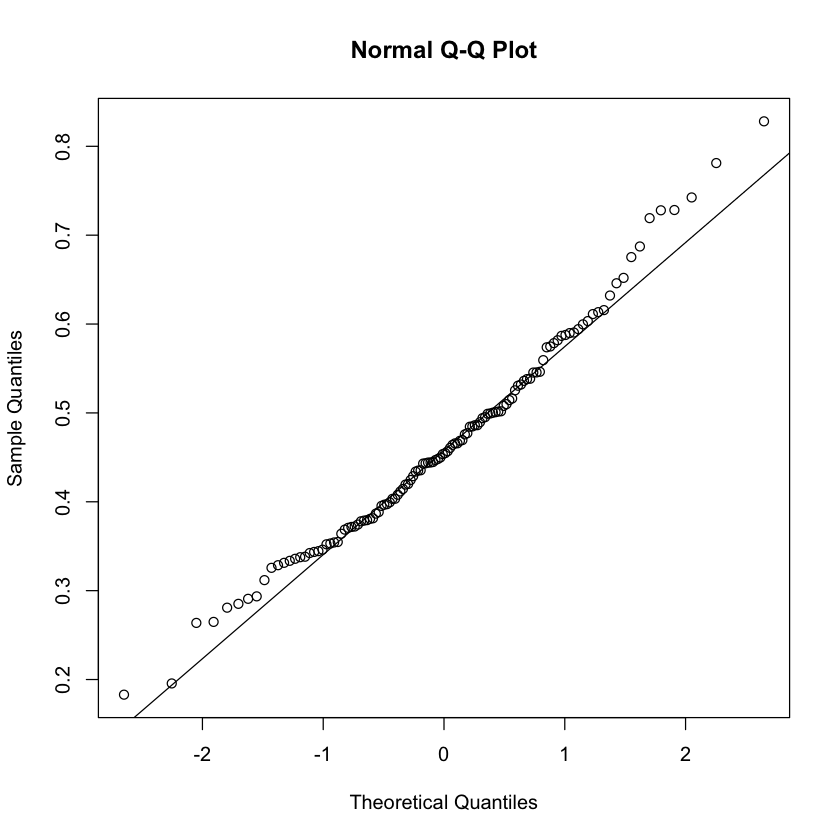

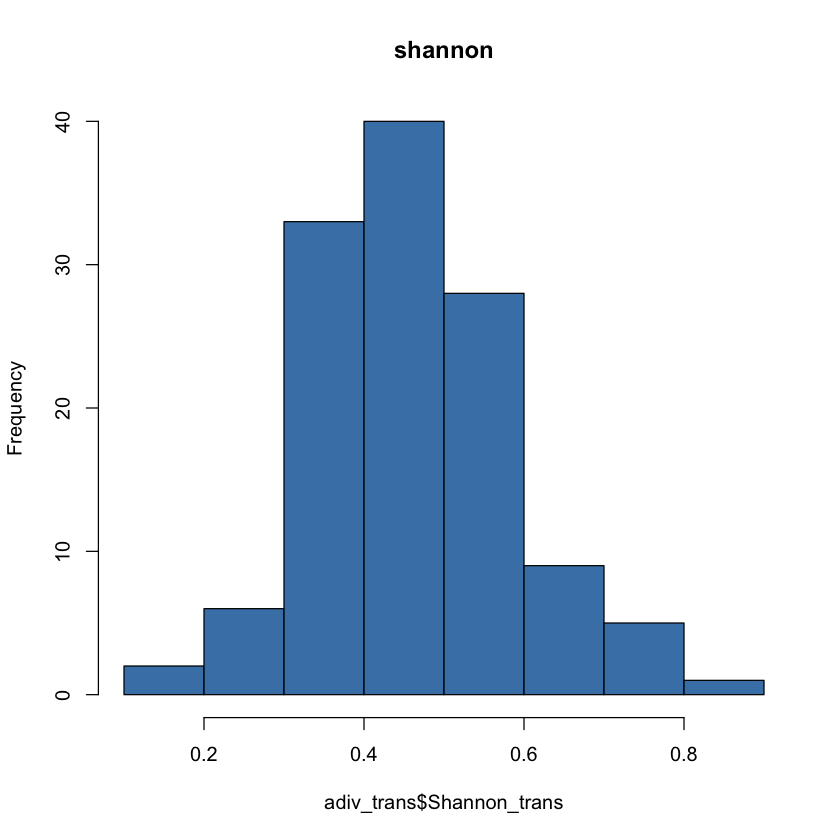

In [16]:
#inspect normalized data
qqnorm(adiv_trans$Shannon_trans)
qqline(adiv_trans$Shannon_trans)
shapiro.test(adiv_trans$Shannon_trans)
hist(adiv_trans$Shannon_trans, col='steelblue', main='shannon')

In [17]:
#combine data with enviornmental data
ps_ra_meta= as(sample_data(ps_fill_rare), "data.frame")
ps_ra_meta_envs = ps_ra_meta %>% select("Genotype", "Samp_trip", "reef",'Speed.cm.s.', 'NO2.uM.', 'NO3.uM.', 'PO4.uM.', 'Si.uM.',
                "Speed.cm.s.", "avgSST_degC", "avgchla_mgm.3", "cluster_depth", "Survivorship_reef")
head(ps_ra_meta_envs)

alpha_envs=cbind(ps_ra_meta_envs, adiv_trans)
head(alpha_envs)

,Genotype,Samp_trip,reef,Speed.cm.s.,NO2.uM.,NO3.uM.,PO4.uM.,Si.uM.,avgSST_degC,avgchla_mgm.3,cluster_depth,Survivorship_reef
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ML2_78_cf_Trip_3,ML2,Trip_3,cf,4.852118,0.032,0.861,0.0685,0.706,29.63623,1.792092,-20.9,0.15
CN4_35_cf_Trip_3,CN4,Trip_3,cf,4.852118,0.032,0.861,0.0685,0.706,29.63623,1.792092,-17.9,0.23
CN4_25_cf_Trip_3,CN4,Trip_3,cf,4.852118,0.032,0.861,0.0685,0.706,29.63623,1.792092,-20.8,0.23
HS1_18_cf_Trip_3,HS1,Trip_3,cf,4.852118,0.032,0.861,0.0685,0.706,29.63623,1.792092,-18.8,0.80
HS1_17_cf_Trip_3,HS1,Trip_3,cf,4.852118,0.032,0.861,0.0685,0.706,29.63623,1.792092,-17.8,NA
HS1_15_cf_Trip_3,HS1,Trip_3,cf,4.852118,0.032,0.861,0.0685,0.706,29.63623,1.792092,-17.6,0.90


,Genotype,Samp_trip,reef,Speed.cm.s.,NO2.uM.,NO3.uM.,PO4.uM.,Si.uM.,avgSST_degC,avgchla_mgm.3,cluster_depth,Survivorship_reef,sample_bag,Shannon,Shannon_trans
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
ML2_78_cf_Trip_3,ML2,Trip_3,cf,4.852118,0.032,0.861,0.0685,0.706,29.63623,1.792092,-20.9,0.15,ML2_78_cf_Trip_3,2.144486,0.3313232
CN4_35_cf_Trip_3,CN4,Trip_3,cf,4.852118,0.032,0.861,0.0685,0.706,29.63623,1.792092,-17.9,0.23,CN4_35_cf_Trip_3,4.487037,0.6519596
CN4_25_cf_Trip_3,CN4,Trip_3,cf,4.852118,0.032,0.861,0.0685,0.706,29.63623,1.792092,-20.8,0.23,CN4_25_cf_Trip_3,2.806583,0.4481778
HS1_18_cf_Trip_3,HS1,Trip_3,cf,4.852118,0.032,0.861,0.0685,0.706,29.63623,1.792092,-18.8,0.80,HS1_18_cf_Trip_3,2.780941,0.4441918
HS1_17_cf_Trip_3,HS1,Trip_3,cf,4.852118,0.032,0.861,0.0685,0.706,29.63623,1.792092,-17.8,NA,HS1_17_cf_Trip_3,4.011722,0.6033309
HS1_15_cf_Trip_3,HS1,Trip_3,cf,4.852118,0.032,0.861,0.0685,0.706,29.63623,1.792092,-17.6,0.90,HS1_15_cf_Trip_3,3.510937,0.5454230


In [18]:
alpha_all=cbind(ps_ra_meta, adiv_trans)
dim(alpha_all)

[1] 124  61

## linear mixed models for shannon diversity 

In [19]:
mixed.lmer_geno <- lmer(Shannon_trans ~ -1 + Genotype + (1|Samp_trip:reef) , data =alpha_all)
summary(mixed.lmer_geno)

emmeans(mixed.lmer_geno, pairwise ~ -1 + Genotype, adjust="tukey")

Linear mixed model fit by REML ['lmerMod']
Formula: Shannon_trans ~ -1 + Genotype + (1 | Samp_trip:reef)
   Data: alpha_all

REML criterion at convergence: -167.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.0050 -0.7166 -0.1147  0.6988  2.7765 

Random effects:
 Groups         Name        Variance  Std.Dev.
 Samp_trip:reef (Intercept) 0.0004956 0.02226 
 Residual                   0.0125255 0.11192 
Number of obs: 124, groups:  Samp_trip:reef, 12

Fixed effects:
            Estimate Std. Error t value
GenotypeCN2  0.49628    0.01973   25.16
GenotypeCN4  0.51326    0.02265   22.66
GenotypeHS1  0.44315    0.01999   22.17
GenotypeML2  0.40326    0.02302   17.52

Correlation of Fixed Effects:
            GntCN2 GntCN4 GntHS1
GenotypeCN4 0.092               
GenotypeHS1 0.105  0.093        
GenotypeML2 0.091  0.091  0.092 

$emmeans
 Genotype emmean     SE   df lower.CL upper.CL
 CN2       0.496 0.0197 62.7    0.457    0.536
 CN4       0.513 0.0228 73.8    0.468    0.559
 HS1       0.443 0.0200 64.3    0.403    0.483
 ML2       0.403 0.0231 77.8    0.357    0.449

Degrees-of-freedom method: kenward-roger 
Confidence level used: 0.95 

$contrasts
 contrast  estimate     SE  df t.ratio p.value
 CN2 - CN4  -0.0170 0.0287 114  -0.591  0.9346
 CN2 - HS1   0.0531 0.0266 110   1.999  0.1946
 CN2 - ML2   0.0930 0.0290 114   3.206  0.0093
 CN4 - HS1   0.0701 0.0289 113   2.430  0.0773
 CN4 - ML2   0.1100 0.0308 111   3.568  0.0030
 HS1 - ML2   0.0399 0.0291 112   1.369  0.5213

Degrees-of-freedom method: kenward-roger 
P value adjustment: tukey method for comparing a family of 4 estimates 


In [20]:
mixed.lmer_geno <- lmer(Shannon_trans ~ -1 + reef + (1|Genotype:Samp_trip) , data =alpha_all)
summary(mixed.lmer_geno)

emmeans(mixed.lmer_geno, pairwise ~ -1 + reef, adjust="tukey")

Linear mixed model fit by REML ['lmerMod']
Formula: Shannon_trans ~ -1 + reef + (1 | Genotype:Samp_trip)
   Data: alpha_all

REML criterion at convergence: -164.9

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.01247 -0.69662  0.03349  0.65872  2.59309 

Random effects:
 Groups             Name        Variance Std.Dev.
 Genotype:Samp_trip (Intercept) 0.002453 0.04953 
 Residual                       0.012183 0.11038 
Number of obs: 124, groups:  Genotype:Samp_trip, 16

Fixed effects:
        Estimate Std. Error t value
reefcf   0.47855    0.02388   20.04
reefndr  0.48186    0.02032   23.71
reefpr   0.44073    0.02047   21.53

Correlation of Fixed Effects:
        reefcf refndr
reefndr 0.319        
reefpr  0.318  0.368 

$emmeans
 reef emmean     SE   df lower.CL upper.CL
 cf    0.479 0.0240 56.4    0.431    0.527
 ndr   0.482 0.0203 37.5    0.441    0.523
 pr    0.441 0.0205 38.4    0.399    0.482

Degrees-of-freedom method: kenward-roger 
Confidence level used: 0.95 

$contrasts
 contrast estimate     SE  df t.ratio p.value
 cf - ndr -0.00331 0.0260 111  -0.127  0.9911
 cf - pr   0.03783 0.0261 111   1.448  0.3201
 ndr - pr  0.04114 0.0229 107   1.794  0.1766

Degrees-of-freedom method: kenward-roger 
P value adjustment: tukey method for comparing a family of 3 estimates 


In [21]:
mixed.lmer_geno <- lmer(Shannon_trans ~ -1 + Samp_trip + (1|Genotype) , data =alpha_all)
summary(mixed.lmer_geno)

emmeans(mixed.lmer_geno, pairwise ~ -1 + Samp_trip, adjust="tukey")

Linear mixed model fit by REML ['lmerMod']
Formula: Shannon_trans ~ -1 + Samp_trip + (1 | Genotype)
   Data: alpha_all

REML criterion at convergence: -164.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.9372 -0.7199 -0.1039  0.7022  3.0163 

Random effects:
 Groups   Name        Variance Std.Dev.
 Genotype (Intercept) 0.001983 0.04453 
 Residual             0.012652 0.11248 
Number of obs: 124, groups:  Genotype, 4

Fixed effects:
                Estimate Std. Error t value
Samp_tripTrip_2  0.43447    0.02946   14.75
Samp_tripTrip_3  0.47849    0.02966   16.13
Samp_tripTrip_4  0.50078    0.03115   16.08
Samp_tripTrip_5  0.44869    0.03035   14.79

Correlation of Fixed Effects:
            Sm_T_2 Sm_T_3 Sm_T_4
Smp_trpTr_3 0.568               
Smp_trpTr_4 0.542  0.539        
Smp_trpTr_5 0.556  0.552  0.529 

$emmeans
 Samp_trip emmean     SE   df lower.CL upper.CL
 Trip_2     0.434 0.0295 6.25    0.363    0.506
 Trip_3     0.478 0.0297 6.42    0.407    0.550
 Trip_4     0.501 0.0312 7.74    0.428    0.573
 Trip_5     0.449 0.0304 7.00    0.377    0.520

Degrees-of-freedom method: kenward-roger 
Confidence level used: 0.95 

$contrasts
 contrast        estimate     SE  df t.ratio p.value
 Trip_2 - Trip_3  -0.0440 0.0275 117  -1.601  0.3820
 Trip_2 - Trip_4  -0.0663 0.0291 117  -2.280  0.1085
 Trip_2 - Trip_5  -0.0142 0.0282 117  -0.504  0.9580
 Trip_3 - Trip_4  -0.0223 0.0293 117  -0.762  0.8714
 Trip_3 - Trip_5   0.0298 0.0284 117   1.049  0.7208
 Trip_4 - Trip_5   0.0521 0.0298 117   1.745  0.3053

Degrees-of-freedom method: kenward-roger 
P value adjustment: tukey method for comparing a family of 4 estimates 


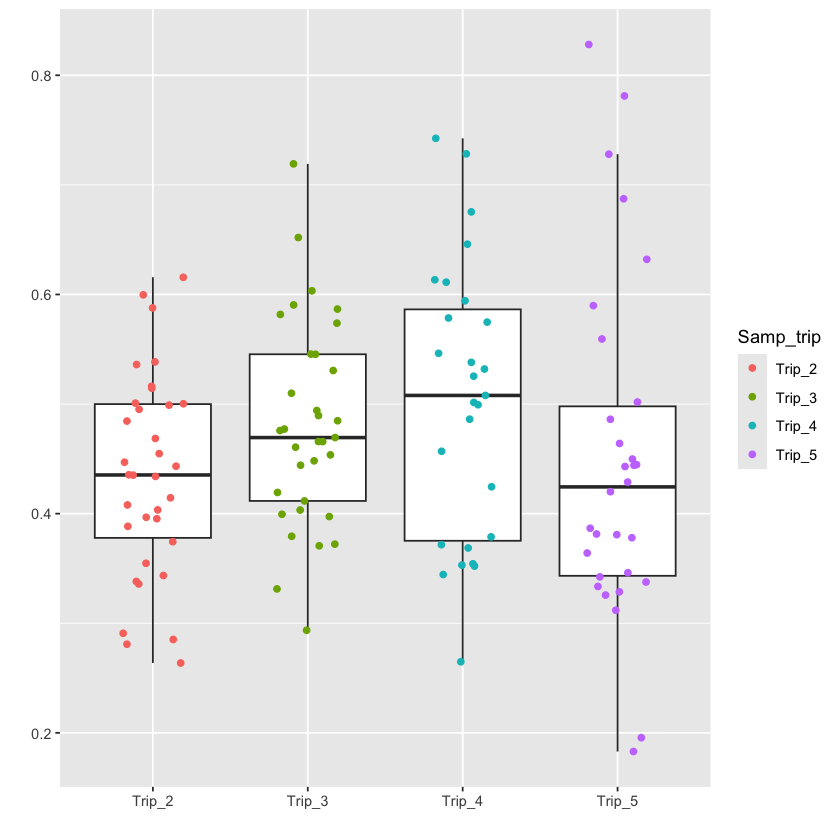

In [22]:
alpha_all %>%
 ggplot(aes(x = Samp_trip, y = Shannon_trans))  +
  geom_boxplot(outlier.color = NA)  +
geom_jitter(aes(color = Samp_trip), height = 0, width = .2) +
  labs(x = "", y = "")

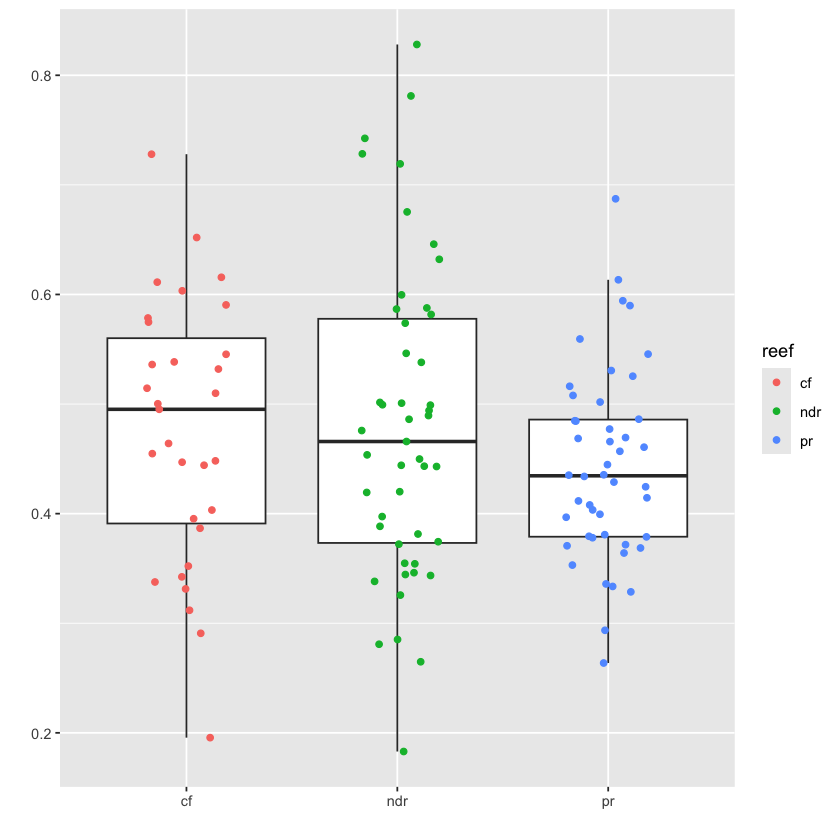

In [23]:
alpha_all %>%
 ggplot(aes(x = reef, y = Shannon_trans))  +
  geom_boxplot(outlier.color = NA)  +
geom_jitter(aes(color = reef), height = 0, width = .2) +
  labs(x = "", y = "")